In [98]:
import numpy as np
import scipy.sparse as sp
from sklearn.neighbors import kneighbors_graph
import math

class Isomap:
    def __init__(self, n_components=2, n_neighbors=5):
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.graph_ = None
        self.distance_graph_ = None
        self.embedding_ = None

    def fit_transform(self, X):
        # Compute pairwise distances
        self.graph_ = kneighbors_graph(X, n_neighbors= self.n_neighbors ).toarray()
        
        # Compute shortest path distances
        D = sp.csgraph.shortest_path(self.graph_, method='D')

        D = D**2

        """
        n_nodes = D.shape[0]

        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j and D[i,j]== 0:
                    D[i,j] = math.inf 

        
        for k in range(n_nodes):
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if D[i,k] + D[k,j] < D[i,j]:
                        D[i,j] = D[i,k] + D[k,j]
        """

        # symmetrize!
        for i in range((D.shape[0])):
            for j in range((D.shape[0])):
                if D[i,j] != D[j,i]:
                    k = np.min([D[i,j], D[j,i]])
                    D[i,j] = k
                    D[j,i] = k

        self.distance_graph_ = D
        # Apply MDS to the distance matrix
        # double center
        n = D.shape[0]
        one_n = np.ones((n, n)) / n
        G = (D - one_n.dot(D) - D.dot(one_n) + one_n.dot(D).dot(one_n))
        G = -(1/2 )* G

        if np.any(np.isnan(G)) | np.any(np.isinf(G)):
            raise RuntimeError("Graph is disconnected: please increase the number of neighbors")

        eig_vals, eig_vecs = np.linalg.eig(G)
        eig_vals = np.where(eig_vals<0,0, eig_vals)
        sorted_indices = np.argsort(eig_vals)[::-1]
        sorted_eigvecs = eig_vecs[:,sorted_indices]
        sorted_eigvals = eig_vals[sorted_indices]

        # select the first k eigenvector(s) and project
        top_k_eigvecs = sorted_eigvecs[:,:self.n_components]
        top_k_eigvals = sorted_eigvals[:self.n_components]


        # Compute final embedding
        self.embedding_ = np.dot(top_k_eigvecs, np.sqrt(np.diag(top_k_eigvals)))

        return self.embedding_


Text(0.5, 1.0, 'Reconstructed spiral with hand-made isomap')

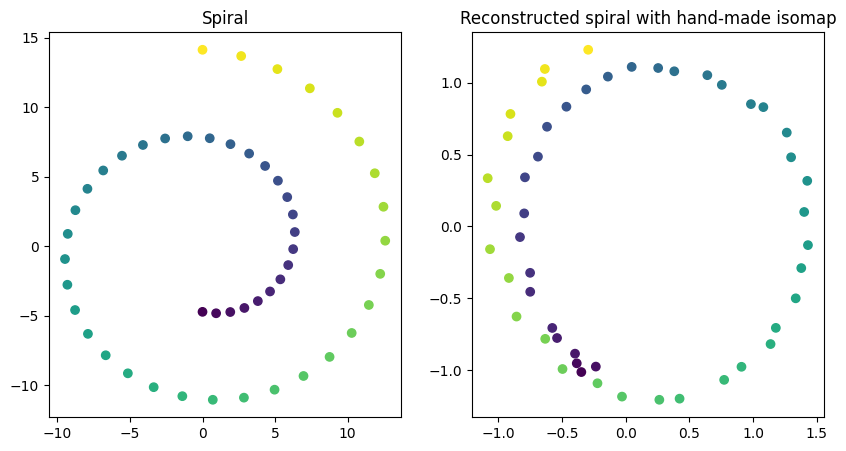

In [68]:
import math
from matplotlib import pyplot as plt
N = 50

phi = np.linspace(1.5*math.pi, 4.5*math.pi, N)

x = phi*np.cos(phi)
y = phi*np.sin(phi)

X = np.array([x,y]).reshape(2,N).T


map = Isomap(n_components=2, n_neighbors=5)
Y = map.fit_transform(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.scatter(x,y, c = phi)
ax1.set_title('Spiral')

ax2.scatter(Y[:,0], Y[:,1], c = phi)
ax2.set_title('Reconstructed spiral with hand-made isomap')


Text(0.5, 1.0, 'Reconstructed circle with hand-made isomap')

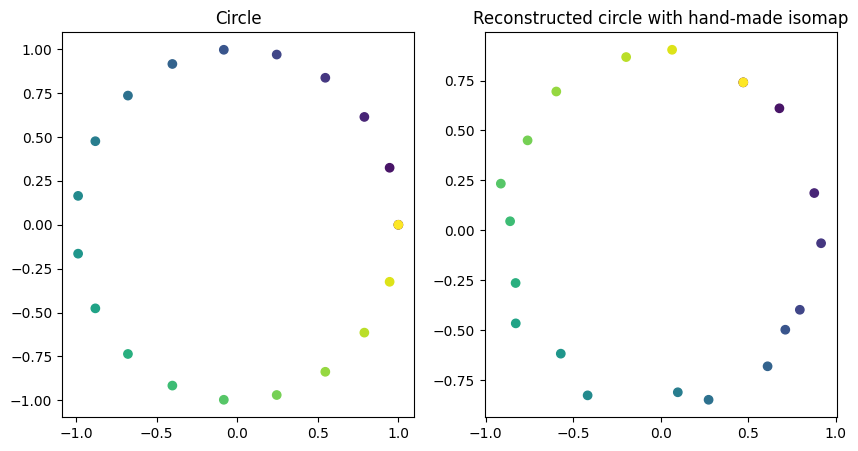

In [69]:
import math
from matplotlib import pyplot as plt
N = 20

phi = np.linspace(0, 2*math.pi, N)

x = np.cos(phi)
y = np.sin(phi)


X = np.array([x,y]).reshape(2,N).T


map = Isomap(n_components=2)
Y = map.fit_transform(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.scatter(x,y, c = phi)
#_ = [ax1.text(x[i]+0.1, y[i]+0.1, str(i)) for i in range(len(x))]
ax1.set_title('Circle')

ax2.scatter(Y[:,0], Y[:,1], c = phi)
#_ = [ax2.text(Y[i,0]+0.1, Y[i,1]+0.1, str(i)) for i in range(len(x))]
ax2.set_title('Reconstructed circle with hand-made isomap')


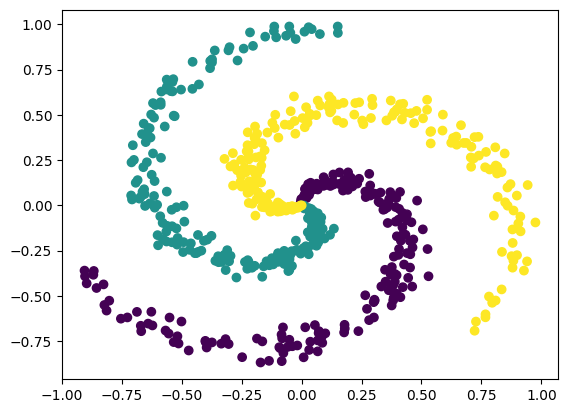

In [70]:
import numpy as np

N = 200  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes

X = np.zeros((N * C, D))
y = np.zeros((N * C, ), dtype=int)

for c in range(C):
    index = 0
    t = np.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = np.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + np.random.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * np.array((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'Reconstructed data')

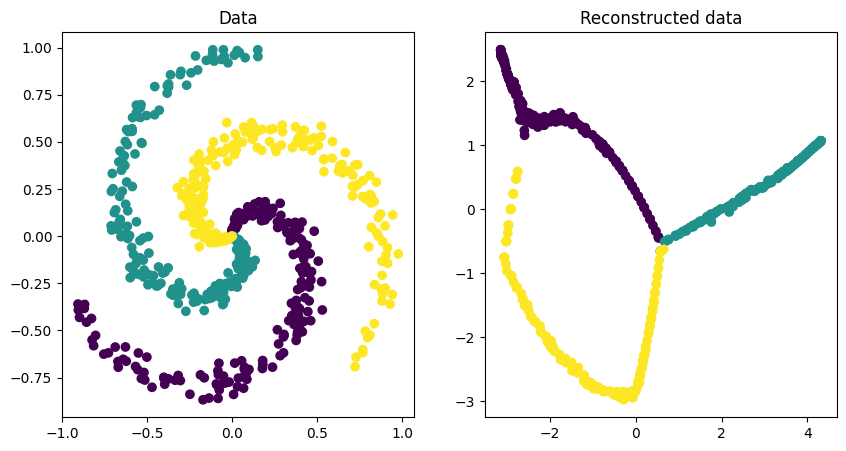

In [71]:
map = Isomap(n_components=2, n_neighbors=9)
Y = map.fit_transform(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.scatter(X[:, 0], X[:, 1], c=y)
ax1.set_title('Data')

ax2.scatter(Y[:,0], Y[:,1], c = y)

ax2.set_title('Reconstructed data')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'Reconstructed data')

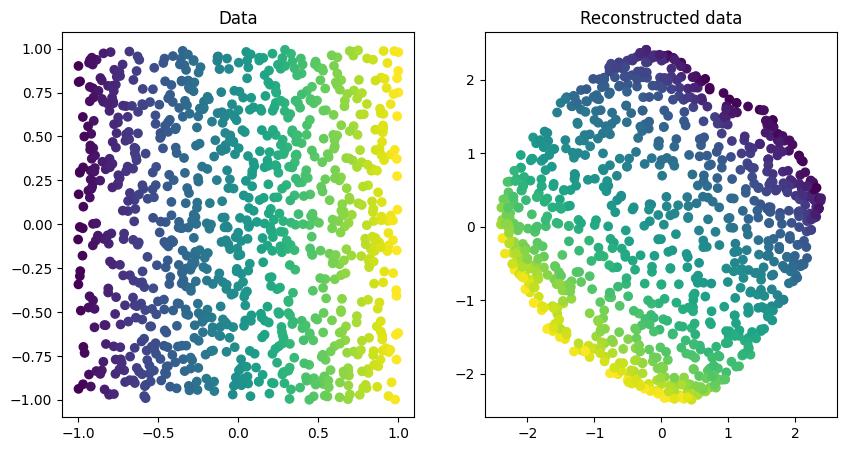

In [76]:
import matplotlib.pyplot as plt

# Generate dataset
n_points = 1000
x = np.random.uniform(low=-1, high=1, size=n_points)
y = np.random.uniform(low=-1, high=1, size=n_points)

X = np.array([x,y]).reshape(2,n_points).T


map = Isomap(n_components=2, n_neighbors=9)
Y = map.fit_transform(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.scatter(x, y, c=x)
ax1.set_title('Data')

ax2.scatter(Y[:,0], Y[:,1], c = x)

ax2.set_title('Reconstructed data')



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


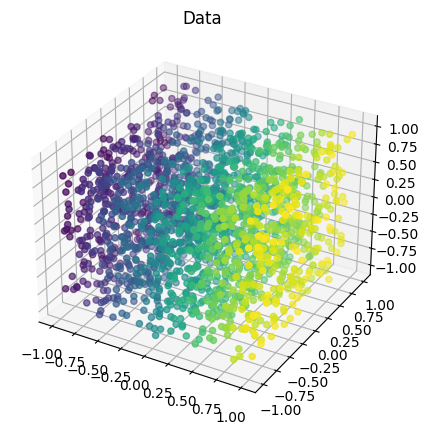

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:550: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asarray(self.convert_xunits(offsets[:, 0]), 'float'),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:551: ComplexWarning: Casting complex values to real discards the imaginary part
  np.asarray(self.convert_yunits(offsets[:, 1]), 'float')))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/colors.py:389: ComplexWarning: Casting complex values to real discards the imaginary part
  c = tuple(map(float, c))


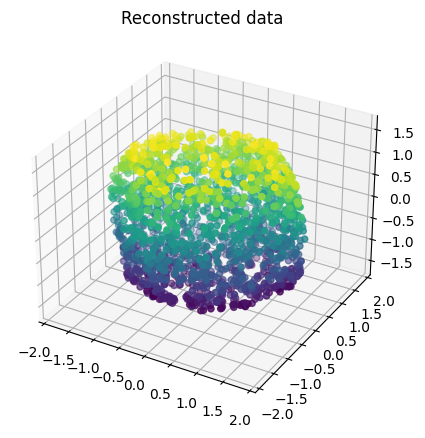

In [83]:
import matplotlib.pyplot as plt

# Generate dataset
n_points = 2000
x = np.random.uniform(low=-1, high=1, size=n_points)
y = np.random.uniform(low=-1, high=1, size=n_points)
z = np.random.uniform(low=-1, high=1, size=n_points)

X = np.array([x,y,z]).reshape(3,n_points).T


map = Isomap(n_components=3, n_neighbors=10)
Y = map.fit_transform(X)

fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter3D(x, y, z, c=x)
ax1.set_title('Data')


fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter3D(Y[:,0], Y[:,1], Y[:,2], c = x)
ax2.set_title('Reconstructed data')

plt.show()

<class 'matplotlib.axes._subplots.Axes3DSubplot'>


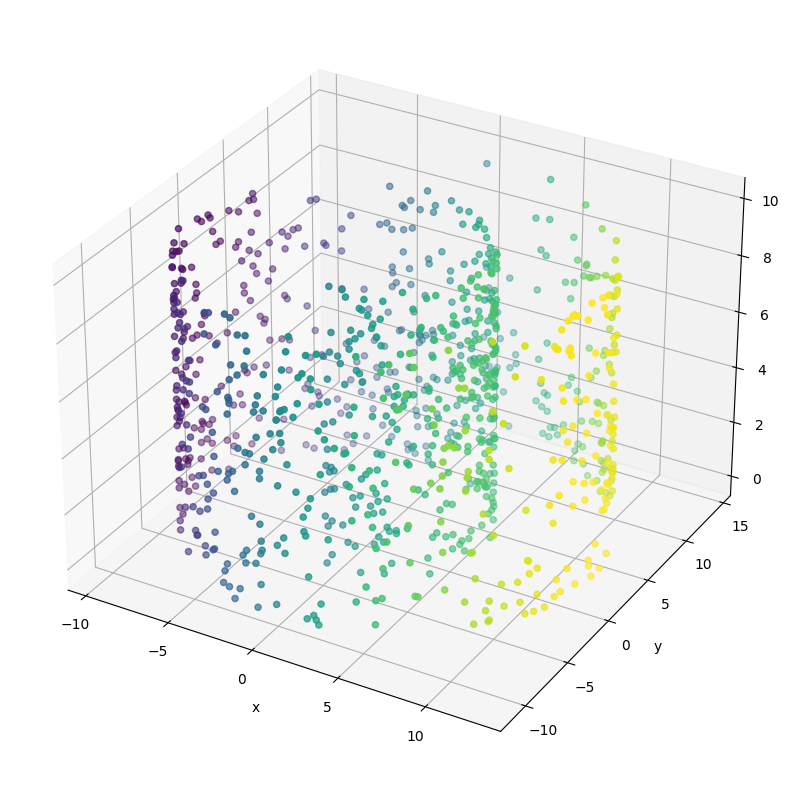

In [91]:
def swiss_roll(n):
    """
    Parameters:
    n: int
        Number of points to generate"""
    
    data = np.zeros((n,3))
    phi = np.random.uniform(low=1.5*np.pi, high=4.5*np.pi, size=n)
    psi = np.random.uniform(0,10,n)
            
    data[:,0]=phi*np.cos(phi) #x coordinte
    data[:,1]=phi*np.sin(phi) #y coordinate
    data[:,2]=psi #z coordinate
    return data

N = 1000
X = swiss_roll(N)

plt.figure(figsize=(12,10))
axes = plt.axes(projection='3d')
print(type(axes))
axes.scatter3D(X[:,0], X[:,1], X[:,2], c=X[:,0])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')

#axes.view_init(45, 45) #(elevation, azimuth angle)

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


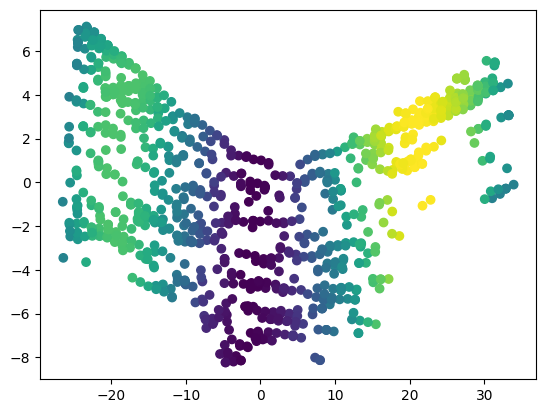

In [99]:
map = Isomap(n_components=2, n_neighbors=9)
Y = map.fit_transform(X)

plt.scatter(Y[:,0], Y[:,1], c = X[:,0])

In [50]:
G = np.array([np.inf,3,4])
np.any(np.isnan(G)) | np.any(np.isinf(G))

True